In [1]:
%run ./Definitions.ipynb

2019-12-19 14:35:14.385183
thunder  Thu Dec 19 14:35:14 2019
[0] GeForce GTX 1080 Ti | 39'C,   0 % |  1476 / 11178 MB | hemelinr(1466M)
[1] GeForce GTX 1080 Ti | 25'C,   0 % |  4556 / 11178 MB | hemelinr(4546M)
[2] GeForce GTX 1080 Ti | 26'C,   0 % | 10895 / 11178 MB | anthoula(10885M)
[3] GeForce GTX 1080 Ti | 29'C,   0 % |    10 / 11178 MB |
[4] GeForce GTX 1080 Ti | 25'C,   0 % |  4759 / 11178 MB | hemelinr(4546M) srikanth(203M)
[5] GeForce GTX 1080 Ti | 27'C,   0 % | 10799 / 11178 MB | gerritsn(10789M)
[6] GeForce GTX 1080 Ti | 55'C,  16 % | 10895 / 11178 MB | patra(10885M)
[7] GeForce GTX 1080 Ti | 50'C,  27 % | 10895 / 11178 MB | patra(10885M)


/ds/environments/python2020/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.
/ds/environments/python2020/lib/python3.7/site-packages/keras/callbacks/callbacks.py:19: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


Dataset consist of 85730 patients data with 6251 features for each patient
Function definitions executed
Definitions DONE !!



In [2]:
!nvidia-smi
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "3"   # choose here your GPU (0-7)

import tensorflow as tf
import tensorflow.compat.v1 as tf
import keras
# from keras import backend as K
import tensorflow.python.keras.backend as K

Thu Dec 19 14:35:28 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 29%   39C    P2    56W / 250W |   1476MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 29%   25C    P8     7W / 250W |   4556MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [3]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

### LOAD valid train test and validation image names 

In [4]:
valid_traindf_names = pd.read_pickle(funduspath_CR + 'valid_traindf_names.pkl')
valid_valdf_names = pd.read_pickle(funduspath_CR + 'valid_valdf_names.pkl')
valid_testdf_names = pd.read_pickle(funduspath_CR + 'valid_testdf_names.pkl')

valid_traindf_names.shape , valid_valdf_names.shape , valid_testdf_names.shape

((101834, 5), (33943, 5), (33936, 5))

In [5]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

## Handling Imbalanced Data sets

In [6]:
which_gt = 3 # CHANGE 1,2,3,4 implies 'GT523', 'GT19', 'GTi', 'GTu'
n_NG = 0 # non glaucoma
n_G = 0  # glaucoma

GT_dict = {1:'GT523',2:'GT19',3:'GTi',4:'GTu'}
Class = GT_dict[which_gt]
temp = valid_traindf_names[Class]
for i in range(len(temp)):
    if(temp[i] == '1'):
        n_G += 1
    else:
        n_NG += 1
        
print("No. of Glaucoma patients in training set:",n_G)
print("No. of non-Glaucoma patients in training set:",n_NG)

No. of Glaucoma patients in training set: 661
No. of non-Glaucoma patients in training set: 101173


### 1. Over Sampling

In [7]:
# Oversample the minority class

X_train = valid_traindf_names['Fundus_Filenames']
y_train = valid_traindf_names[GT_dict[which_gt]]

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_glaucoma = X[X[Class]=='0']
glaucoma = X[X[Class]=='1']

# upsample minority
glaucoma_upsampled = resample(glaucoma,
                              replace=True, # sample with replacement
                              n_samples=len(not_glaucoma), # match number in majority class
                              random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_glaucoma,glaucoma_upsampled])

# Converting class values to int 1 or 0
upsampled[Class] = upsampled[Class].astype(int)

# shuffle upsampled dataframe for training
upsampled = upsampled.sample(frac=1)


In [8]:
upsampled[Class].value_counts()

1    101173
0    101173
Name: GTi, dtype: int64

In [9]:
valid_valdf_names[Class].value_counts()

0    33733
1      210
Name: GTi, dtype: int64

## Define Model and Metrics

In [10]:
# reg_values = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6] # 1e-1, 
reg_value = 0.001
METRICS = [keras.metrics.BinaryAccuracy(name='Accuracy'),
           Precision, 
           Recall, 
           F1,
           keras.metrics.AUC(name='AUC')]

def mobilenet_model():       
    mobile_conv = MobileNet(weights='imagenet', include_top=False, input_shape=(red_size, red_size, 3))

    # UnFreeze last conv layer
    for layer in mobile_conv.layers[:81]:
        layer.trainable = False
    for layer in mobile_conv.layers[81:]:
        layer.trainable = True
        
    # Create the model
    model = models.Sequential()
    model.add(mobile_conv)
    
    # https://adventuresinmachinelearning.com/global-average-pooling-convolutional-neural-networks/
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(1, activation='sigmoid'))
 
    return model

### Augmentation
https://nbviewer.jupyter.org/github/aleju/imgaug-doc/blob/master/notebooks/A01%20-%20Load%20and%20Augment%20an%20Image.ipynb

In [11]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Affine(scale=1.1),
    iaa.Affine(rotate=(-10, 10)),
    iaa.GammaContrast(0.9),
    iaa.Resize({"height": 230, "width": 230}),
    iaa.CropToFixedSize(width=red_size, height=red_size)
    ])

### Flow from Dataframe
https://www.kaggle.com/dmitrypukhov/cnn-with-imagedatagenerator-flow-from-dataframe

In [12]:
# To use same settings as mobilenet
# from keras.applications.mobilenet import preprocess_input
# train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

train_datagen = ImageDataGenerator(preprocessing_function=seq.augment_image, samplewise_center=True, rescale= 1./255) 
val_datagen = ImageDataGenerator(samplewise_center=True, rescale=1./255)  
BATCH_SIZE = 32

train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = upsampled, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = upsampled.columns[0], # upsampled data
    y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=valid_valdf_names,
    directory=valpath,
    x_col=valid_valdf_names.columns[0],
    y_col=valid_valdf_names.columns[which_gt],
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)


Found 202346 validated image filenames.
Found 33943 validated image filenames.


In [13]:
# which_model = make_model
which_model = mobilenet_model
# which_model = vgg_model
model = which_model()

learning_rate  = 0.001 
decay = 1e-5
opt = Adam(lr=learning_rate, decay = decay) 
model.compile(loss='binary_crossentropy', metrics=METRICS, optimizer=opt)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 3,229,889
Trainable params: 1,062,913
Non-trainable params: 2,166,976
_________________________________________________________________


In [14]:
# With L2 weight regularizer
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.000001, verbose=1)
keras_model_path = funduspath_CR + 'Models/'
n_epochs=150
n_steps_per_epoch = 50
n_validation_steps = 10

In [15]:
start = time.time()
history = model.fit_generator(train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps, 
                              callbacks=[reduce_lr]
                             )
end = time.time()

/ds/environments/python2020/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:339: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(values, collections.Sequence):


Epoch 1/150
50/50 [==============================] - 53s 1s/step - loss: 0.8273 - Accuracy: 0.6219 - Precision: 0.6300 - Recall: 0.6324 - F1: 0.6202 - AUC: 0.6767 - val_loss: 10.3455 - val_Accuracy: 0.0063 - val_Precision: 0.0063 - val_Recall: 0.2000 - val_F1: 0.0121 - val_AUC: 0.5000
Epoch 2/150
50/50 [==============================] - 51s 1s/step - loss: 0.6044 - Accuracy: 0.7056 - Precision: 0.7218 - Recall: 0.7159 - F1: 0.7103 - AUC: 0.7808 - val_loss: 1.5973 - val_Accuracy: 0.3063 - val_Precision: 0.0083 - val_Recall: 0.2000 - val_F1: 0.0160 - val_AUC: 0.4312
Epoch 3/150
50/50 [==============================] - 52s 1s/step - loss: 0.5681 - Accuracy: 0.7075 - Precision: 0.7022 - Recall: 0.7098 - F1: 0.6981 - AUC: 0.7921 - val_loss: 1.1445 - val_Accuracy: 0.4969 - val_Precision: 0.0118 - val_Recall: 0.2000 - val_F1: 0.0223 - val_AUC: 0.5865
Epoch 4/150
50/50 [==============================] - 52s 1s/step - loss: 0.5491 - Accuracy: 0.7294 - Precision: 0.7369 - Recall: 0.7519 - F1: 0.

50/50 [==============================] - 52s 1s/step - loss: 0.2687 - Accuracy: 0.9000 - Precision: 0.8779 - Recall: 0.9319 - F1: 0.9005 - AUC: 0.9629 - val_loss: 0.2327 - val_Accuracy: 0.8875 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6377
Epoch 56/150
50/50 [==============================] - 52s 1s/step - loss: 0.2740 - Accuracy: 0.9000 - Precision: 0.8701 - Recall: 0.9361 - F1: 0.8977 - AUC: 0.9614 - val_loss: 0.1816 - val_Accuracy: 0.9000 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5841
Epoch 57/150
50/50 [==============================] - 52s 1s/step - loss: 0.2656 - Accuracy: 0.9050 - Precision: 0.8806 - Recall: 0.9318 - F1: 0.9019 - AUC: 0.9649 - val_loss: 0.5013 - val_Accuracy: 0.8625 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.0000e+00
Epoch 58/150
50/50 [==============================] - 52s 1s/step - loss: 0.2840 - Accuracy: 0.8913 - Precision: 0.

Epoch 83/150
50/50 [==============================] - 52s 1s/step - loss: 0.2640 - Accuracy: 0.9075 - Precision: 0.8790 - Recall: 0.9451 - F1: 0.9084 - AUC: 0.9654 - val_loss: 0.3509 - val_Accuracy: 0.8750 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7618
Epoch 84/150
50/50 [==============================] - 51s 1s/step - loss: 0.2645 - Accuracy: 0.9056 - Precision: 0.8783 - Recall: 0.9407 - F1: 0.9033 - AUC: 0.9643 - val_loss: 0.2596 - val_Accuracy: 0.8719 - val_Precision: 0.0200 - val_Recall: 0.1000 - val_F1: 0.0333 - val_AUC: 0.7355
Epoch 85/150
50/50 [==============================] - 52s 1s/step - loss: 0.2758 - Accuracy: 0.9006 - Precision: 0.8890 - Recall: 0.9340 - F1: 0.9071 - AUC: 0.9598 - val_loss: 0.2999 - val_Accuracy: 0.8469 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4469
Epoch 86/150
50/50 [==============================] - 53s 1s/step - loss: 0.2553 - Accuracy: 0.9150 - Precision: 0.901

Epoch 111/150
50/50 [==============================] - 53s 1s/step - loss: 0.2847 - Accuracy: 0.8900 - Precision: 0.8600 - Recall: 0.9246 - F1: 0.8868 - AUC: 0.9569 - val_loss: 0.4748 - val_Accuracy: 0.8750 - val_Precision: 0.0500 - val_Recall: 0.1000 - val_F1: 0.0667 - val_AUC: 0.9326
Epoch 112/150
50/50 [==============================] - 53s 1s/step - loss: 0.2605 - Accuracy: 0.9044 - Precision: 0.8956 - Recall: 0.9280 - F1: 0.9083 - AUC: 0.9669 - val_loss: 0.2405 - val_Accuracy: 0.8625 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5401
Epoch 113/150
50/50 [==============================] - 53s 1s/step - loss: 0.2718 - Accuracy: 0.9019 - Precision: 0.8850 - Recall: 0.9310 - F1: 0.9026 - AUC: 0.9612 - val_loss: 0.3062 - val_Accuracy: 0.8344 - val_Precision: 0.0268 - val_Recall: 0.2000 - val_F1: 0.0472 - val_AUC: 0.8978
Epoch 114/150
50/50 [==============================] - 53s 1s/step - loss: 0.2755 - Accuracy: 0.9062 - Precision: 0.8834 - Reca

Epoch 139/150
50/50 [==============================] - 52s 1s/step - loss: 0.2600 - Accuracy: 0.9112 - Precision: 0.8832 - Recall: 0.9529 - F1: 0.9134 - AUC: 0.9650 - val_loss: 0.4012 - val_Accuracy: 0.8531 - val_Precision: 0.0250 - val_Recall: 0.1000 - val_F1: 0.0400 - val_AUC: 0.9112
Epoch 140/150
50/50 [==============================] - 53s 1s/step - loss: 0.2834 - Accuracy: 0.8988 - Precision: 0.8745 - Recall: 0.9311 - F1: 0.8953 - AUC: 0.9576 - val_loss: 0.2408 - val_Accuracy: 0.8625 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6912
Epoch 141/150
50/50 [==============================] - 52s 1s/step - loss: 0.2545 - Accuracy: 0.9075 - Precision: 0.8896 - Recall: 0.9366 - F1: 0.9081 - AUC: 0.9700 - val_loss: 0.3548 - val_Accuracy: 0.8656 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4217
Epoch 142/150
50/50 [==============================] - 52s 1s/step - loss: 0.2623 - Accuracy: 0.9044 - Precision: 0

In [16]:
print("Time taken:",end-start)

Time taken: 7842.855132818222


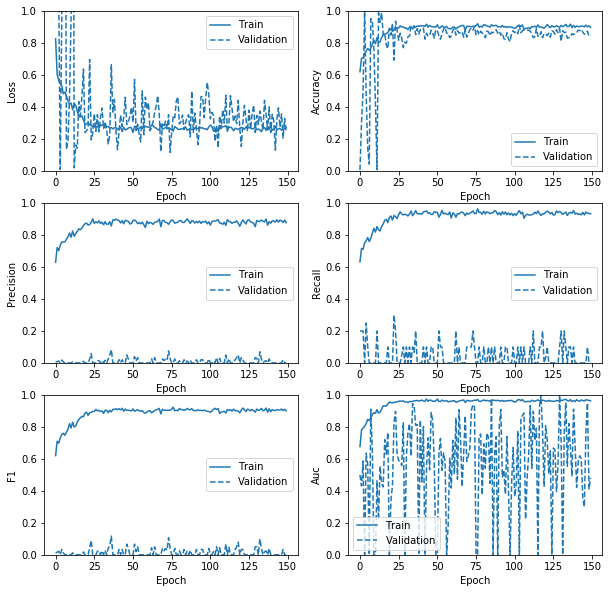

In [17]:
plt.figure(figsize=(10,10))
plot_metrics(history)

## Evaluation

In [18]:
results_tr = model.evaluate(train_generator,steps=100)
results_vl = model.evaluate(validation_generator,steps=100)

100/100 [==============================] - 18s 176ms/step


In [19]:
print("NAME :\tTRAIN :\tVALIDATION ")
for name, value_tr, value_vl in zip(model.metrics_names, results_tr, results_vl):
    print("%s : %5.3f : %7.3f" %(name, value_tr , value_vl))


NAME :	TRAIN :	VALIDATION 
loss : 1.156 :   0.318
Accuracy : 0.599 :   0.866
Precision : 0.574 :   0.011
Recall : 0.842 :   0.040
F1 : 0.678 :   0.016
AUC : 0.641 :   0.700


## Prediction
The output of a binary classification is the probability of a sample belonging to a class.

In [ ]:
# PREDICTED LABELS
start = time.time()
pred_tr = model.predict(train_generator)
tr_end = time.time()
pred_vl = model.predict(validation_generator)
vl_end = time.time()

tr_end-start , vl_end-tr_end

In [31]:
# TRUE LABELS

train_labels = upsampled[Class].tolist()
train_labels = [int(i) for i in train_labels]

val_labels = valid_valdf_names[Class].tolist()
val_labels = [int(i) for i in val_labels]


In [32]:
np.save(funduspath_CR + str(n_epochs) + 'ep_gap_pred_tr_81unfreze.npy', pred_tr)
np.save(funduspath_CR + str(n_epochs) + 'ep_gap_pred_vl_81unfreze.npy', pred_vl)

### ROC Curve

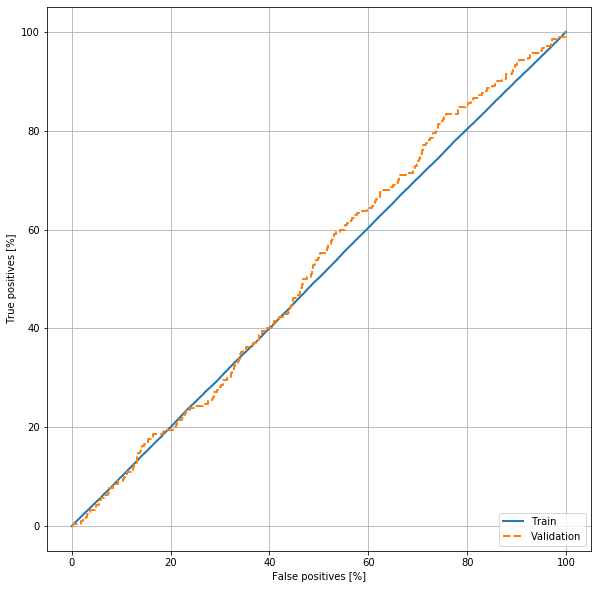

In [33]:
plt.figure(figsize=(10,10))
plot_roc("Train", train_labels, pred_tr, color=colors[0])
plot_roc("Validation", val_labels, pred_vl, color=colors[1],linestyle='--')
plt.legend(loc='lower right')

### Confusion matrix

Train data: 
TN: 26515 
FP: 74658 
FN: 26214 
TP: 74959
Healthy Patients - correctly identified (True Negatives):  26515 0.26207585027625946
Healthy Patients - predicted to have glaucoma (False Positives):  74658 0.7379241497237405
Glaucoma Patients - predicted healthy (False Negatives):  26214 0.2591007482233402
Glaucoma Patients - correctly identified (True Positives):  74959 0.7408992517766598

Total Glaucoma patients:  101173 1.0
Total Healthy patients:  101173 1.0


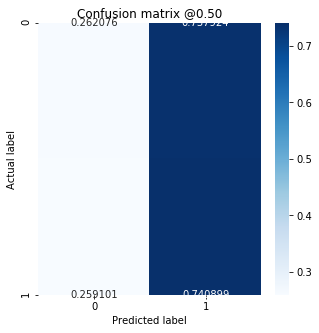

In [38]:
tn, fp, fn, tp = confusion_matrix(train_labels, pred_tr > 0.5).ravel()
train_cm = [tn, fp, fn, tp]
print("Train data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(train_labels, pred_tr)

Validation data: 
TN: 29216 
FP: 4517 
FN: 180 
TP: 30
Healthy Patients - correctly identified (True Negatives):  29216 0.866095514777814
Healthy Patients - predicted to have glaucoma (False Positives):  4517 0.13390448522218598
Glaucoma Patients - predicted healthy (False Negatives):  180 0.8571428571428571
Glaucoma Patients - correctly identified (True Positives):  30 0.14285714285714285

Total Glaucoma patients:  210 1.0
Total Healthy patients:  33733 1.0


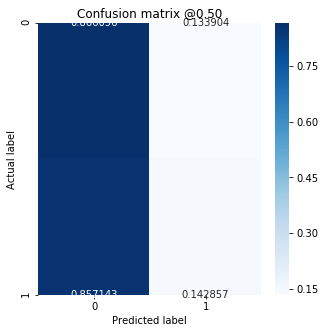

In [37]:
tn, fp, fn, tp = confusion_matrix(val_labels, pred_vl > 0.5).ravel()
val_cm = [tn, fp, fn, tp]
print("Validation data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(val_labels, pred_vl)

### MLFlow 

In [44]:
# history = imb_history
tag_value = "single train same as RUN1-Copy3 with samplewise_center = True"
myname = get_notebook_name()
exp_name = myname +"-run at-"+datetime.datetime.now().strftime("%d%b%Y %H:%M")
keras_model_path = funduspath_CR+ exp_name + '_model'
save_mlflow(keras_model_path,exp_name,which_gt,which_model,seq,BATCH_SIZE,
            n_epochs,n_steps_per_epoch,n_validation_steps,
            reg_value,learning_rate,decay,opt,
            history,results_tr,results_vl,train_cm,val_cm
           )

<IPython.core.display.Javascript object>

In [45]:
client = MlflowClient()
run = client.create_run('14')
client.set_tag(run.info.run_id, "tag_key", tag_value)